# Contents

In [1]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.1.0
Keras Version: 2.2.4-tf

Python 3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]
Pandas 1.3.4
Scikit-Learn 1.0.2
GPU is available


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, \
    plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score, mean_squared_error


from sklearn.linear_model import (
    Ridge,RidgeCV,
    Lasso,LassoCV,
    ElasticNet, ElasticNetCV,
    LinearRegression
)

from sklearn.model_selection import(
    cross_val_score,
    train_test_split
)

from sklearn.preprocessing import (
    StandardScaler,
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier
from xgboost import cv
from xgboost import plot_importance
import xgboost as xgb
use_label_encoder=False

# pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_columns', 50)  # or 1000

# Exploratory Data Analysis

In [340]:
# read in lag7_g1 dataset
lag_train = pd.read_csv('../data/lag7_g1.csv')
lag_test = pd.read_csv('../data/test_lag7_g1.csv')

# read in lag_21_g2 dataset
lag_train_1 = pd.read_csv('../data/lag21_g2.csv')
lag_test_1 = pd.read_csv('../data/test_lag21_g2.csv')

Text(0.69, 0.5, '5.39% of 8475 observations\nare from the Positive class (1),\nie. WNV present')

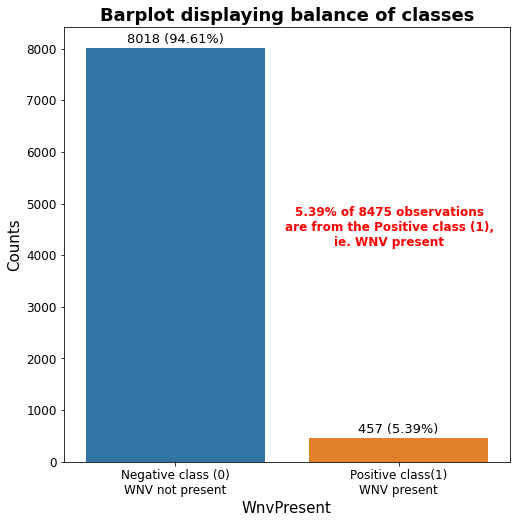

In [7]:
# Plotting the balance of classes on a countplot.

wnv_notpresent = lag_train['wnvpresent'].value_counts()[0]
wnv_present = lag_train['wnvpresent'].value_counts()[1]
neg_pct = lag_train['wnvpresent'].value_counts(normalize=True)[0] * 100
pos_pct = lag_train['wnvpresent'].value_counts(normalize=True)[1] * 100
total = wnv_notpresent + wnv_present

# set up figure size 
plt.figure(figsize=(8,8))

# plot countplot
ax = sns.countplot(x='wnvpresent', data=lag_train)


# set labels for X and y and titles
ax.set_xticklabels(['Negative class (0)\nWNV not present', 'Positive class(1)\nWNV present'])
ax.tick_params(axis='both', labelsize=12)

plt.xlabel("WnvPresent", fontsize=15)
plt.ylabel("Counts", fontsize=15)

plt.title("Barplot displaying balance of classes", fontdict = {'size' : 18, 'weight': 'bold'})

# to plot number of points in each class 
plt.text(x=0, y=wnv_notpresent+100, s=str(wnv_notpresent) + ' (' + str(round(neg_pct,2)) + '%)', fontsize=13, ha='center')
plt.text(x=1, y=wnv_present+100, s=str(wnv_present) + ' (' + str(round(pos_pct,2)) + '%)', fontsize=13, ha='center')

# set up red text 
plt.figtext(x=0.69, 
            y=0.5, 
            s=f"{round(pos_pct, 2)}% of {total} observations\nare from the Positive class (1),\nie. WNV present", 
            fontdict = {'size' : 12, 'weight': 'semibold'},
            ha='center',
            color = 'red',
           )


From the above, we can see that the classes are very unbalanced. Of the 8475 observations, only 457 `(5.5%) are from the positive class` ie. West Nile Virus present (WvvPresent == 1) while 8018 (94.61%) observations from the negative class, ie. West Nile Virus not present (WvvPresent == 0)

We will need to explore ways to balance the two classes before modelling 

# Model Preparation

## Modelling Approaches

As seen from the above, the classes in this case is unbalanced. We will need to deploy balancing techniques like `over-sampling` using imblearn `SMOTE` and also adjust `class_weights` on certain classifiers like RandomForestClassifier. 

We will be using these following models 
- Logistic Regression  
- RandomForestClassifier
- XGboost 

## Classification Matrix

In the context of this project, we define our **positive class as the presence of WNV *(WnvPresent = 1)*, and the negative class as the absence of WNV *(WnvPresent = 0)***.

`Accuracy` is defined as the total number of correct predictions over the total number of predictions made. Essentially, this refers to the correct predictions of mosquitos trapped containing WNV virus over the total number of predictions made.

While `Accuracy` is a good overall measure of the model's performance, a high score doesnt reflect how well it is predicting for each class. For example, having high score, could also mean having very good predictions of mosquitos NOT having WNV (due to high skew of data towards no WnvPresent), that would overshadow class that contains correct predictions for those carrying WNV. 

Hence we need `sensitivity` and `specificity` as well to measure the true positive and true negative rate and achieve balance between the two. 

To answer the part on `calculating the cost involved to deploy the the pesticides` throughout the city of Chicago, having high amount of false positives will result in increased cost for spraying these pesticides. On the other hand, having `large number of false negatives could potentially lead to an outbreak of WNV which would greatly affect the economy should Chicago be forced to take drastic measures to contain it`. Hence, the team has decided it would be better to focus on having **minimal false negatives than *false positives* hence leaning towards `sensitivity` than `specificity`** while not sacrifising too much on `Accuracy`, `ROC_AUC` (how good the model is at predicting) and `Precision` (used to measure the quality of a ***positive prediction made by the model*** where cost of ***Too many False positives* can be a huge short term impact**)

### Instantiate X and y variables

For this iteration onwards, we will be using two main datasets which was chosen to be the best features based on accuracy and high sensitivity scores while both lags then to fit within the timeframe for complete larval development from 7 to 23 days ([ncbi](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3992806/)). 

1) Lag 7 days (group_1) - Based on first pass high test accuracy score
2) Lag 21 days (group_2) - Based on first pass high sensitivity score

Based on internal calculation, we will do full iteration only on 7 days data, but will do final tuning for Lag_21 days data using XGBoost to do comparison as to which model gives best prediction to train and test datasets. 

In [746]:
X = lag_train.drop(columns = ['wnvpresent','date','id'])
y = lag_train['wnvpresent']

In [477]:
X.head(5)

,culex_pipiens/restuans,culex_pipiens,culex_restuans,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,trap_T086,trap_T003,trap_T028,trap_T082,trap_T014,trap_T115,trap_T158,trap_T016,trap_T903,trap_T226,...,trap_T103,trap_T221,trap_T114,trap_T096,trap_T009,trap_T235,trap_T008,trap_T061,trap_T147,trap_T073,tavg,dewpoint,preciptotal,stnpressure,sealevel,resultdir,avgspeed,sunset,br,fu,hz,ra,ts,tsra,vcts
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,73.5,44,0.0,29.41,30.05,16,10.6,19.183333,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,65.5,55,0.0,29.52,30.17,3,6.7,17.933333,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,65.5,55,0.0,29.52,30.17,3,6.7,17.933333,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,64.5,55,0.0,29.46,30.18,2,6.4,17.933333,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,72.5,54,0.0,29.46,30.08,31,7.4,18.850000,0,0,0,0,0,0,0


In [747]:
kaggle_test = lag_test.drop(columns = ['wnvpresent','id'])
kaggle_test.head(5)

,culex_pipiens/restuans,culex_pipiens,culex_restuans,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,trap_T003,trap_T061,trap_T128,trap_T230,trap_T008,trap_T011,trap_T009,trap_T090,trap_T138,trap_T147,...,trap_T233,trap_T225,trap_T095,trap_T103,trap_T030,trap_T228,trap_T223,trap_T031,trap_T015,trap_T221,tavg,dewpoint,preciptotal,stnpressure,sealevel,resultdir,avgspeed,sunset,br,fu,hz,ra,ts,tsra,vcts
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,66.0,59,0.005,28.9,29.62,4,5.2,19.366667,1,0,1,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,66.0,59,0.005,28.9,29.62,4,5.2,19.366667,1,0,1,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,66.0,59,0.005,28.9,29.62,4,5.2,19.366667,1,0,1,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,66.0,59,0.005,28.9,29.62,4,5.2,19.366667,1,0,1,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,66.0,59,0.005,28.9,29.62,4,5.2,19.366667,1,0,1,0,0,1,0


In [479]:
kaggle_test.shape

(116293, 76)

Train test split

In [748]:
# Splitting X and y into training and testing datasets.

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [749]:
# Scaling X_train to the standard scale.

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)

# Transforming X_test to the same scale.

X_test_sc = ss.transform(X_test)

In [750]:
# Transforming actual test dataframe to the same scale (to generate predictions for kaggle submission later).

kaggle_test_sc = ss.transform(kaggle_test)

C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


# Classification Modelling

### Class balancing Technique

We will be using only `smote` for this project

In [ ]:
# instantiate SMOTE
smote = SMOTE(random_state=42)

In [ ]:
X_train_sc_smote, y_train_smote = smote.fit_resample(X_train_sc, y_train)

In [ ]:
# Checking the distribution of classes with SMOTE balancing technique.

y_train_smote.value_counts()

0.0    6013
1.0    6013
Name: wnvpresent, dtype: int64

We can see the library helped balance the proportions between two classes. 

`SMOTE` is an over-sampling method, that creates copies of the minority class data points with small variations, making synthetic samples more diverse [source](https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/). Hence we see the number of data points for the positive class matching with the negative class

### Logistic regression & SMOTE

In [ ]:
# Creating a pipeline object using imblearn.pipeline with SMOTE and LogisticRegression.

pipe_logreg = make_pipeline(SMOTE(random_state=42),
                      LogisticRegression(penalty='elasticnet', solver='saga', random_state=42, max_iter=1000)
                     )

In [ ]:
pipe_logreg.get_params()

{'memory': None,
 'steps': [('smote', SMOTE(random_state=42)),
  ('logisticregression',
   LogisticRegression(max_iter=1000, penalty='elasticnet', random_state=42,
                      solver='saga'))],
 'verbose': False,
 'smote': SMOTE(random_state=42),
 'logisticregression': LogisticRegression(max_iter=1000, penalty='elasticnet', random_state=42,
                    solver='saga'),
 'smote__k_neighbors': 5,
 'smote__n_jobs': None,
 'smote__random_state': 42,
 'smote__sampling_strategy': 'auto',
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 1000,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'elasticnet',
 'logisticregression__random_state': 42,
 'logisticregression__solver': 'saga',
 'logisticre

In [ ]:
# {'logisticregression__C': 2.7777777777777777,
#  'logisticregression__l1_ratio': 1}

In [ ]:
# Establishing ranges of hyperparameters C and l1_ratio for GridSearchCV, and class_weight.

pipe_logreg_params = {
    'logisticregression__C': np.linspace(0,5,10),
    'logisticregression__l1_ratio': [1],
    }

In [ ]:
# Creating a GridSearchCV with scoring of ROC_AUC

gs_logreg = GridSearchCV(pipe_logreg, 
                        param_grid=pipe_logreg_params, 
                        cv=5, 
                        scoring='roc_auc',
                        n_jobs = -1
                       )

In [ ]:
# Fitting GridSearchCV with SMOTE and LogisticRegression on X_train_sc and y_train.

gs_logreg.fit(X_train_sc, y_train)

C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\imblearn\pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\linear_model\_logistic.py", line 1614, in fit
    for class_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           penalty='elasticnet',
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([0.        , 0.55555556, 1.11111111, 1.66666667, 2.22222222,
       2.77777778, 3.33333333, 3.88888889, 4.44444444, 5.        ]),
                         'logisticregression__l1_ratio': [1]},
             scoring='roc_auc')

In [ ]:
gs_logreg.best_params_

{'logisticregression__C': 1.1111111111111112,
 'logisticregression__l1_ratio': 1}

In [ ]:
# Scoring model for all matrix 

train_acc = gs_logreg.score(X_train_sc, y_train)
cross_val_acc = gs_logreg.best_score_
test_acc = gs_logreg.score(X_test_sc, y_test)
preds = gs_logreg.predict(X_test_sc)
y_pred_proba = gs_logreg.predict_proba(X_test_sc)

confusion_matrix(y_test, # True values.
                 preds)# Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
roc_auc  = roc_auc_score(y_test, y_pred_proba[:,1])


C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


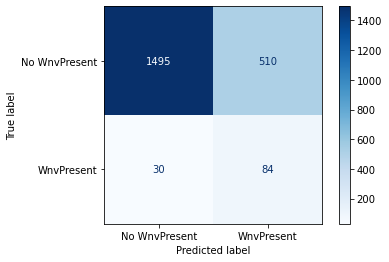

In [ ]:
# Plot Confusion matrix
plot_confusion_matrix(gs_logreg, X_test_sc, y_test, cmap='Blues', 
                      values_format='d', display_labels=['No WnvPresent', 'WnvPresent']);                 

In [ ]:
summary_df = pd.DataFrame(columns=['Classifier',
                                   'Class Balancing Technique',
                                   'Train Accuracy',
                                   'GridSearchCV Accuracy',
                                   'Actual Test Accuracy',
                                   'Overfit (-ve) / Underfit (+ve)',
                                   'Sensitivity',
                                   'Specificity',
                                   'Precision',
                                   'ROC-AUC',
                                  ])

In [ ]:
summary_df.loc[1] = ["LogisticRegression",
                     "SMOTE",
                     round(train_acc, 3),
                     round(cross_val_acc, 3),
                     round(test_acc, 3),
                     round(train_acc-test_acc, 3),
                     round(sensitivity, 3),
                     round(specificity, 3),
                     round(precision, 3),
                     round(roc_auc, 3),
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,GridSearchCV Accuracy,Actual Test Accuracy,Overfit (-ve) / Underfit (+ve),Sensitivity,Specificity,Precision,ROC-AUC
1,LogisticRegression,SMOTE,0.865,0.809,0.811,0.054,0.737,0.746,0.141,0.811


### Random Forest Classifier & SMOTE

In [ ]:
# # Creating a pipeline object using imblearn.pipeline with SMOTE and RandomForestClassifier.

# rfc_smote_pipe = make_pipeline(
#     SMOTE(
#         # sampling_strategy='minority',
#         random_state=42,
#         k_neighbors=21,    
#     ),
#     RandomForestClassifier(
#         n_estimators=2500,
#         ccp_alpha=0,
#         max_depth=3,
#         # min_samples_split=5,
#         # min_samples_leaf=200,
#         random_state=42,
#     )
# )

In [863]:
# Creating a pipeline object using imblearn.pipeline with SMOTE and RandomForestClassifier.

rfc_smote_pipe = make_pipeline(
    SMOTE(
        sampling_strategy='minority',
        random_state=42,
        k_neighbors=3,    
    ),
    RandomForestClassifier(
        n_estimators=2250,
        ccp_alpha=0,
        max_depth=3,
        random_state=42,
    )
)


In [864]:
# Fitting X_train_sc and y_train on the pipeline object defined above.

rfc_smote_pipe.fit(X_train_sc, y_train)

Pipeline(steps=[('smote',
                 SMOTE(k_neighbors=3, random_state=42,
                       sampling_strategy='minority')),
                ('randomforestclassifier',
                 RandomForestClassifier(ccp_alpha=0, max_depth=3,
                                        n_estimators=2250, random_state=42))])

In [865]:
# # Establishing ranges of hyperparameters for GridSearchCV

# pipe_rfs_smote = {
#     'randomforestclassifier__n_estimators': np.linspace(2000,5000,5, dtype=int)
#     # 'randomforestclassifier__max_depth': [3,5,8],
#     # 'randomforestclassifier__min_samples_leaf': [3,4,5],
#     # 'randomforestclassifier__min_samples_split': [3,4,5],
#     # 'randomforestclassifier__ccp_alpha': [0.04]
#     }

In [866]:
# # Creating a GridSearchCV with scoring of ROC_AUC with Randomforest

# gs_pipe_rfs_smote = GridSearchCV(rfc_smote_pipe, 
#                         param_grid=pipe_rfs_smote, 
#                         cv=3, 
#                         scoring='roc_auc',
#                         n_jobs = -1
#                        )

In [867]:
# # Fitting GridSearchCV with Random Forest Classifier

# gs_pipe_rfs_smote.fit(X_train_sc, y_train)

In [868]:
# gs_pipe_rfs_smote.best_params_

In [873]:
# Scoring model for all matrix 

train_acc = rfc_smote_pipe.score(X_train_sc, y_train)
cross_val_acc = cross_val_score(rfc_smote_pipe, X_train_sc,y_train, cv=3).mean()
test_acc = rfc_smote_pipe.score(X_test_sc, y_test)
preds = rfc_smote_pipe.predict(X_test_sc)
y_pred_proba = rfc_smote_pipe.predict_proba(X_test_sc)
confusion_matrix(y_test, # True values.
                 preds)# Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
roc_auc  = roc_auc_score(y_test, y_pred_proba[:,1])


C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


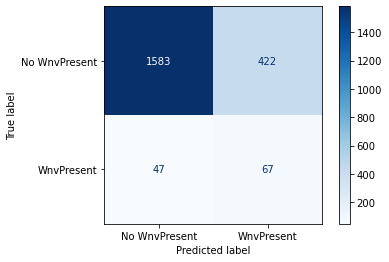

In [874]:
# Plot Confusion matrix
plot_confusion_matrix(rfc_smote_pipe, X_test_sc, y_test, cmap='Blues', 
                      values_format='d', display_labels=['No WnvPresent', 'WnvPresent']);                 

In [875]:
summary_df.loc[2] = ["RandomForestClassifier",
                     "SMOTE",
                     round(train_acc, 3),
                     round(cross_val_acc, 3),
                     round(test_acc, 3),
                     round(train_acc-test_acc, 3),
                     round(sensitivity, 3),
                     round(specificity, 3),
                     round(precision, 3),
                     round(roc_auc, 3),
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,GridSearchCV Accuracy,Actual Test Accuracy,Overfit (-ve) / Underfit (+ve),Sensitivity,Specificity,Precision,ROC-AUC
1,LogisticRegression,SMOTE,0.865,0.809,0.811,0.054,0.737,0.746,0.141,0.811
2,RandomForestClassifier,SMOTE,0.787,0.775,0.779,0.009,0.588,0.790,0.137,0.764
3,RandomForestClassifier,Hyperparameter: Balanced Subsample,0.776,0.776,0.757,0.019,0.746,0.758,0.149,0.826
4,SVC,Hyperparameter: Balanced,0.650,0.776,0.615,0.034,0.667,0.612,0.089,0.704
5,XGBoost,Hyperparameter: Scale_pos_weight,0.749,0.752,0.729,0.020,0.807,0.725,0.143,0.831


In [876]:
=

SyntaxError: invalid syntax (1763773627.py, line 1)

After tuning `RandomForestClassifier with Smote`, we can see that the accuracy and ROC-AUC is better than `LogisticRegression`. 

However, sensitivity will be hard to tune upwards while maintaining high precision and ROC_AUC. Bumping up the sensitivity will bring down overall accuracy, ROC_AUC and Precision. Anything below below ROC_AUC score of 0.8 will not be good as per ([source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2935260/#:~:text=The%20area%20under%20the%20ROC,AUC%20values%20between%200.5%2D0.6.)). Hence, we can explore tuning RandomForestClassifier with balanced subsample.

### Random Forest Classifier & Hyperparameter class_weight = `balance_subsample`

We will be manually tuning the parameters as GridsearchCV will only optimise the model based on one scoring parameter. There is a need to find a balance between multiple matrix like accuracy, sensitivity, specifity, precision and ROC_AUC. 


In [ ]:
rfs_hyperparam_bal =  RandomForestClassifier(
        n_estimators=1000,
        ccp_alpha=0,
        max_depth=10,
        min_samples_split=3,
        min_samples_leaf=3,
        random_state=42,
        class_weight='balanced_subsample')

In [ ]:
# Fitting X_train_sc and y_train on RandomForestClassifier object defined above.

rfs_hyperparam_bal.fit(X_train_sc, y_train)

RandomForestClassifier(ccp_alpha=0, class_weight='balanced_subsample',
                       max_depth=10, min_samples_leaf=3, min_samples_split=3,
                       n_estimators=1000, random_state=42)

In [ ]:
# # Establishing ranges of hyperparameters for GridSearchCV

# pipe_rfs_hyperparam_bal = {
#     'randomforestclassifier__n_estimators': [100,200,300],
#     'randomforestclassifier__max_depth': [5,6],
#     'randomforestclassifier__max_features': ['sqrt','log2',None],
#     'randomforestclassifier__min_samples_split': [4,5],
#     'randomforestclassifier__min_samples_leaf': [2,3,4] 
#     }

In [ ]:
# # Creating a GridSearchCV with scoring of ROC_AUC with Randomforest

# gs_rfs_hyperparam_bal = GridSearchCV(rfs_hyperparam_bal, 
#                         param_grid=pipe_rfs_hyperparam_bal, 
#                         cv=5, 
#                         scoring='roc_auc',
#                         n_jobs = -1
#                        )

In [ ]:
# Fitting GridSearchCV with Random Forest Classifier

rfs_hyperparam_bal.fit(X_train_sc, y_train)

RandomForestClassifier(ccp_alpha=0, class_weight='balanced_subsample',
                       max_depth=10, min_samples_leaf=3, min_samples_split=3,
                       n_estimators=1000, random_state=42)

In [ ]:
# # Best params for rfs with SMOTE
# gs_rfs_hyperparam_bal.best_params_

In [ ]:
# Scoring model for all matrix 

train_acc = rfs_hyperparam_bal.score(X_train_sc, y_train)
cross_val_acc = cross_val_score(rfs_hyperparam_bal,X_train_sc,y_train, cv = 5).mean()
test_acc = rfs_hyperparam_bal.score(X_test_sc, y_test)
preds = rfs_hyperparam_bal.predict(X_test_sc)
y_pred_proba = rfs_hyperparam_bal.predict_proba(X_test_sc)

confusion_matrix(y_test, # True values.
                 preds)# Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
roc_auc  = roc_auc_score(y_test, y_pred_proba[:,1])


C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


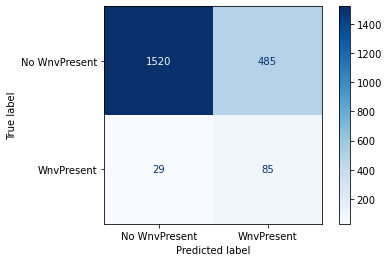

In [ ]:
# Plot Confusion matrix
plot_confusion_matrix(rfs_hyperparam_bal, X_test_sc, y_test, cmap='Blues', 
                      values_format='d', display_labels=['No WnvPresent', 'WnvPresent']);                 

In [ ]:
summary_df.loc[3] = ["RandomForestClassifier",
                     "Hyperparameter: Balanced Subsample",
                     round(train_acc, 3),
                     round(cross_val_acc, 3),
                     round(test_acc, 3),
                     round(train_acc-test_acc, 3),
                     round(sensitivity, 3),
                     round(specificity, 3),
                     round(precision, 3),
                     round(roc_auc, 3),
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,GridSearchCV Accuracy,Actual Test Accuracy,Overfit (-ve) / Underfit (+ve),Sensitivity,Specificity,Precision,ROC-AUC
1,LogisticRegression,SMOTE,0.865,0.809,0.811,0.054,0.737,0.746,0.141,0.811
2,RandomForestClassifier,SMOTE,0.793,0.792,0.781,0.012,0.570,0.793,0.135,0.756
3,RandomForestClassifier,Hyperparameter: Balanced Subsample,0.776,0.776,0.757,0.019,0.746,0.758,0.149,0.826


This hyperparameter tuning enables RandomForestClassifier to handle unbalanced dataset without using the oversampling method, SMOTE. Although the test accuracy suffers a little, the sensitivity and ROC_AUC improved. 

### SVC with Smote

In [906]:
svc_smote_pipe3 = make_pipeline(
    SMOTE(
        random_state=42,
    ),
    SVC(
        C=0.1,
        kernel='rbf',
        probability=True, 
        random_state=42
    )
)

In [907]:
# Fitting X_train_sc and y_train on the pipeline object defined above.

svc_smote_pipe3.fit(X_train_sc, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('svc', SVC(C=0.01, probability=True, random_state=42))])

In [911]:
# Scoring model for all matrix 

train_acc = svc_smote_pipe3.score(X_train_sc, y_train)
cross_val_acc = cross_val_score(svc_smote_pipe3, X_train_sc,y_train, cv = 3).mean()
test_acc = svc_smote_pipe3.score(X_test_sc, y_test)
preds = svc_smote_pipe3.predict(X_test_sc)
y_pred_proba = svc_smote_pipe3.predict_proba(X_test_sc)

confusion_matrix(y_test, # True values.
                 preds)# Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
roc_auc  = roc_auc_score(y_test, y_pred_proba[:,1])


In [920]:
summary_df.loc[4] = ["SVC",
                     "SMOTE",
                     round(train_acc, 3),
                     round(cross_val_acc, 3),
                     round(test_acc, 3),
                     round(train_acc-test_acc, 3),
                     round(sensitivity, 3),
                     round(specificity, 3),
                     round(precision, 3),
                     round(roc_auc, 3),
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,GridSearchCV Accuracy,Actual Test Accuracy,Overfit (-ve) / Underfit (+ve),Sensitivity,Specificity,Precision,ROC-AUC
1,LogisticRegression,SMOTE,0.865,0.809,0.811,0.054,0.737,0.746,0.141,0.811
2,RandomForestClassifier,SMOTE,0.787,0.775,0.779,0.009,0.588,0.790,0.137,0.764
3,RandomForestClassifier,Hyperparameter: Balanced Subsample,0.776,0.776,0.757,0.019,0.746,0.758,0.149,0.826
4,SVC,SMOTE,0.650,0.526,0.615,0.034,0.667,0.612,0.089,0.704
5,SVC,Hyperparameter: Balanced,0.650,0.526,0.615,0.034,0.667,0.612,0.089,0.704


The SVC with Smote despite multiple tuning, was unable to get a good accuracy score while achieving higher sensitivity score. 

SVC is generally difficult to tune to get what we intended to achieve. Overall, its accuracy/specificity score are not as competitive as the rest of the models. Overall ROC_AUC is bad too, hence this model will not be useful.

### XGBoost & Hyperparameter tuned: `Scale_pos_weight`

The following steps below will involve using GridSearchCV followed by manual tuning that to ensure that model is able to predict unseen data from kaggle test set. Learning rate was found to be important, as the faster the learning rate, the more it may miss a few data points or correlations which can give better insights into the data, which may lead to lower predicting power. 

In [ ]:
pipe_xgb = Pipeline([    
                    ('xgb',XGBClassifier(
                        objective='binary:logistic',
                        verbosity=1, 
                        n_jobs=-1, 
                        random_state=42, 
                        eval_metric='auc', 
                        use_label_encoder =False)),
                    ])
    
  
pipe_xgb_params = {
'xgb__gamma': [0.5, 1, 2, 3],
'xgb__learning_rate': [0.01, 0.02,0.05,0.1,],
'xgb__max_depth':[15, 20, 30, 40, 50],
'xgb__min_child_weight': [10, 20, 25, 30],
'xgb__n_estimators':[40, 50, 60],
'xgb__scale_pos_weight': [15,20,25],
'xgb__subsample':[0.5, 1]
}

gs_xgb = GridSearchCV(estimator=pipe_xgb, param_grid=pipe_xgb_params, cv=5, scoring='roc_auc', n_jobs = -1)

gs_xgb.fit(X_train_sc, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='auc',
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                      

In [ ]:
gs_xgb.best_params_

{'xgb__gamma': 1,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 15,
 'xgb__min_child_weight': 10,
 'xgb__n_estimators': 50,
 'xgb__scale_pos_weight': 20,
 'xgb__subsample': 1}

Finetune final model to change learning rate. 

In [922]:
# fit XGBoost on training data

xbg_model = XGBClassifier(
    scale_pos_weight=20,
    learning_rate = 0.03,  
    subsample = 1,
    objective='binary:logistic',
    reg_alpha = 15,
    max_depth= 8, 
    min_child_weight = 10,
    use_label_encoder=False,
    eval_metric = 'auc',
    gamma = 1,
    random_state = 42

)
                  
eval_set = [(X_test_sc,y_test)]

# use AUC as eval matric
xbg_model.fit(
    X_train_sc,
    y_train,
    early_stopping_rounds=10,
    eval_set=eval_set,
    verbose = False,
    eval_metric='auc'
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=8, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=15, reg_lambda=1, scale_pos_weight=20, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [923]:
# Scoring model for all matrix 

train_acc = xbg_model.score(X_train_sc, y_train)
cross_val_acc = cross_val_score(xbg_model, X_train_sc, y_train, cv = 3).mean()
test_acc = xbg_model.score(X_test_sc, y_test)
preds = xbg_model.predict(X_test_sc)
y_pred_proba = xbg_model.predict_proba(X_test_sc)

confusion_matrix(y_test, # True values.
                 preds)# Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
roc_auc  = roc_auc_score(y_test, y_pred_proba[:,1])


C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


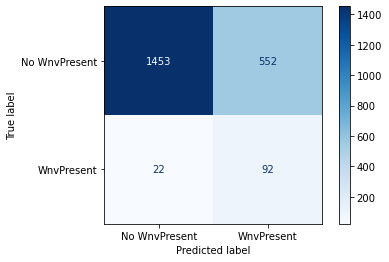

In [924]:
# Plot Confusion matrix
plot_confusion_matrix(xbg_model, X_test_sc, y_test, cmap='Blues', 
                      values_format='d', display_labels=['No WnvPresent', 'WnvPresent']);                 

In [925]:
summary_df.loc[5] = ["XGBoost",
                    'Hyperparameter: Scale_pos_weight',
                     round(train_acc, 3),
                     round(cross_val_acc, 3),
                     round(test_acc, 3),
                     round(train_acc-test_acc, 3),
                     round(sensitivity, 3),
                     round(specificity, 3),
                     round(precision, 3),
                     round(roc_auc, 3),
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,GridSearchCV Accuracy,Actual Test Accuracy,Overfit (-ve) / Underfit (+ve),Sensitivity,Specificity,Precision,ROC-AUC
1,LogisticRegression,SMOTE,0.865,0.809,0.811,0.054,0.737,0.746,0.141,0.811
2,RandomForestClassifier,SMOTE,0.787,0.775,0.779,0.009,0.588,0.790,0.137,0.764
3,RandomForestClassifier,Hyperparameter: Balanced Subsample,0.776,0.776,0.757,0.019,0.746,0.758,0.149,0.826
4,SVC,SMOTE,0.650,0.526,0.615,0.034,0.667,0.612,0.089,0.704
5,XGBoost,Hyperparameter: Scale_pos_weight,0.749,0.752,0.729,0.020,0.807,0.725,0.143,0.831


`XGBoost` has the `highest ROC_AUC, sensitivity, specificity hence with good precision score` compared to the other models. Although it suffers from the train accuracies, it is relatively better fitted, achieving the best balance between bias and variance, allowing the model to predict well with unseen data. Although it has the a low precision, the priority is to strongly predict true wnv containing places in order to prevent a huge outbreak that may cause further monetary damage than just spending on spraying. Like they say, better be safe than sorry.  

#### Kaggle Submission

In [926]:
# fit in whole data set 
xbg_model.fit(X,y)

# create submission predict proba 
submission_pred_proba= xbg_model.predict_proba(kaggle_test_sc)[:, 1]

# Putting the above predicted probabilities into a dataframe and exporting it as a csv file for submission to kaggle.

submission = pd.DataFrame({'Id' : lag_test['id'].values, 'WnvPresent' : submission_pred_proba})
submission.Id = submission.Id.astype('int')
submission.to_csv('../kaggle_submission/submission_XGBoost_lag_7.csv', index=False)

Kaggle score submitted: 0.67

### Finetune Lag_21 data

Fine tuning model and run on lag21_g2 dataset 

In [929]:
X_lag21 = lag_train_1.drop(columns = ['wnvpresent'])
y_lag21 = lag_train_1['wnvpresent']

In [930]:
X_lag21.head(5)

,culex_pipiens/restuans,culex_pipiens,culex_restuans,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,trap_T086,trap_T003,trap_T028,trap_T082,trap_T033,trap_T014,trap_T215,trap_T115,trap_T158,trap_T016,...,trap_T065,trap_T114,trap_T096,trap_T009,trap_T045,trap_T235,trap_T008,trap_T061,trap_T147,trap_T073,tavg,dewpoint,preciptotal,stnpressure,sealevel,resultdir,avgspeed,sunset,br,fu,hz,ra,ts,tsra,vcts
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,70.0,57,0.005,29.36,30.02,8,5.4,18.950000,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,66.5,55,0.000,29.49,30.14,4,4.4,18.366667,1,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,66.5,55,0.000,29.49,30.14,4,4.4,18.366667,1,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,64.5,54,0.000,29.44,30.15,4,4.1,18.366667,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,80.5,58,0.000,29.36,30.00,6,5.8,19.150000,0,0,0,0,0,0,0


In [931]:
kaggle_test_lag21 = lag_test_1.drop(columns = ['wnvpresent','id'])
kaggle_test_lag21.head(5)

,culex_pipiens/restuans,culex_pipiens,culex_restuans,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,trap_T135,trap_T027,trap_T014,trap_T015,trap_T209,trap_T047,trap_T008,trap_T033,trap_T158,trap_T103,...,trap_T223,trap_T900,trap_T128,trap_T073,trap_T212,trap_T002,trap_T151,trap_T016,trap_T233,trap_T138,tavg,dewpoint,preciptotal,stnpressure,sealevel,resultdir,avgspeed,sunset,br,fu,hz,ra,ts,tsra,vcts
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,53.5,36,0.0,29.0,29.7,32,9.2,19.166667,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,53.5,36,0.0,29.0,29.7,32,9.2,19.166667,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,53.5,36,0.0,29.0,29.7,32,9.2,19.166667,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,53.5,36,0.0,29.0,29.7,32,9.2,19.166667,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,53.5,36,0.0,29.0,29.7,32,9.2,19.166667,0,0,0,0,0,0,0


In [932]:
kaggle_test_lag21.shape

(116293, 87)

Train test split

In [933]:
# Splitting X and y into training and testing datasets.

X_train_lag21, X_test_lag21, y_train_lag21, y_test_lag21 = train_test_split(X_lag21, y_lag21, stratify=y, random_state=42)

In [934]:
# Scaling X_train to the standard scale.

ss = StandardScaler()
X_train_sc_lag21 = ss.fit_transform(X_train_lag21)

# Transforming X_test to the same scale.

X_test_sc_lag21 = ss.transform(X_test_lag21)

In [935]:
# Transforming actual test dataframe to the same scale (to generate predictions for kaggle submission later).

kaggle_test_sc_lag21 = ss.transform(kaggle_test_lag21)

C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


#### Finetune XGBoost on Lag21 data

In [936]:
# fit XGBoost on training data

xbg_model_21 = XGBClassifier(
    scale_pos_weight=19,
    learning_rate = 0.1,  
    subsample = 1,
    objective='binary:logistic',
    reg_alpha = 0.5,
    max_depth= 6, 
    min_child_weight = 10,
    use_label_encoder=False,
    eval_metric = 'auc',
    gamma = 0.5,
    random_state = 42

)
                  
eval_set = [(X_test_sc_lag21,y_test_lag21)]

# use AUC as eval matric
xbg_model_21.fit(
    X_train_sc_lag21,
    y_train_lag21,
    early_stopping_rounds=10,
    eval_set=eval_set,
    verbose = False,
    eval_metric='auc'
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0.5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0.5, reg_lambda=1, scale_pos_weight=19, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [937]:
# Scoring model for all matrix 

train_acc = xbg_model_21.score(X_train_sc_lag21, y_train_lag21)
cross_val_acc = cross_val_score(xbg_model_21, X_train_sc_lag21, y_train_lag21, cv = 3).mean()
test_acc = xbg_model_21.score(X_test_sc_lag21, y_test_lag21)
preds = xbg_model_21.predict(X_test_sc_lag21)
y_pred_proba = xbg_model_21.predict_proba(X_test_sc_lag21)

confusion_matrix(y_test_lag21, # True values.
                 preds)# Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test_lag21, preds).ravel();

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
roc_auc  = roc_auc_score(y_test_lag21, y_pred_proba[:,1])


C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


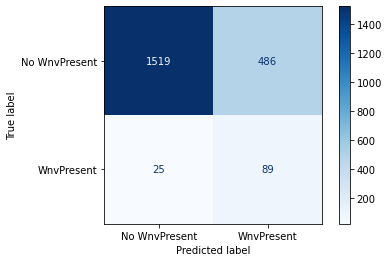

In [938]:
# Plot Confusion matrix
plot_confusion_matrix(xbg_model_21, X_test_sc_lag21, y_test_lag21, cmap='Blues', 
                      values_format='d', display_labels=['No WnvPresent', 'WnvPresent']);                 

In [939]:
summary_df_lag_21 = pd.DataFrame(columns=['Classifier',
                                   'Class Balancing Technique',
                                   'Train Accuracy',
                                   'GridSearchCV Accuracy',
                                   'Actual Test Accuracy',
                                   'Overfit (-ve) / Underfit (+ve)',
                                   'Sensitivity',
                                   'Specificity',
                                   'Precision',
                                   'ROC-AUC',
                                  ])

In [940]:
summary_df_lag_21.loc[0] = ["XGBoost on Lag_21",
                    'Hyperparameter: Scale_pos_weight',
                     round(train_acc, 3),
                     round(cross_val_acc, 3),
                     round(test_acc, 3),
                     round(train_acc-test_acc, 3),
                     round(sensitivity, 3),
                     round(specificity, 3),
                     round(precision, 3),
                     round(roc_auc, 3),
                    ]

summary_df_lag_21

,Classifier,Class Balancing Technique,Train Accuracy,GridSearchCV Accuracy,Actual Test Accuracy,Overfit (-ve) / Underfit (+ve),Sensitivity,Specificity,Precision,ROC-AUC
0,XGBoost on Lag_21,Hyperparameter: Scale_pos_weight,0.784,0.778,0.759,0.025,0.781,0.758,0.155,0.841


#### Kaggle Submission

In [941]:
# fit in whole data set 
xbg_model_21.fit(X_lag21,y_lag21)

# create submission predict proba 
submission_pred_proba= xbg_model_21.predict_proba(kaggle_test_sc_lag21)[:, 1]

# Putting the above predicted probabilities into a dataframe and exporting it as a csv file for submission to kaggle.

submission = pd.DataFrame({'Id' : lag_test['id'].values, 'WnvPresent' : submission_pred_proba})
submission.Id = submission.Id.astype('int')
submission.to_csv('../kaggle_submission/submission_XGBoost_lag_21.csv', index=False)

Kaggle score submitted: 0.45 

Kaggle score for Lag_21 is bad as compared to Lag_7 indicating that the correlation to weather lagging by 7 days is more accurate in depicting the lifecycle and breeding of mosquitos, especially those which carries the virus. 

Using this model as the final model, we are going to retrain the model with the whole train dataset for better prediction power. 

In [ ]:
# retrain whole dataset

xbg_model.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0.5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0.5, reg_lambda=1, scale_pos_weight=21, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [ ]:
# Generating prediction probabilities on actual testing dataset using the model above (for kaggle submission).

submission_pred_proba= xbg_model.predict_proba(kaggle_test_sc)[:, 1]

In [ ]:
submission_pred_proba.shape

(116293,)

In [ ]:
lag_test

,id,culex_pipiens/restuans,culex_pipiens,culex_restuans,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,trap_T003,trap_T061,trap_T128,trap_T230,trap_T008,trap_T011,trap_T009,trap_T090,trap_T138,...,trap_T225,trap_T095,trap_T103,trap_T030,trap_T228,trap_T223,trap_T031,trap_T015,trap_T221,wnvpresent,tavg,dewpoint,preciptotal,stnpressure,sealevel,resultdir,avgspeed,sunset,br,fu,hz,ra,ts,tsra,vcts
0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN,66.0,59,0.005,28.90,29.62,4,5.2,19.366667,1,0,1,0,0,1,0
1,2.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN,66.0,59,0.005,28.90,29.62,4,5.2,19.366667,1,0,1,0,0,1,0
2,3.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN,66.0,59,0.005,28.90,29.62,4,5.2,19.366667,1,0,1,0,0,1,0
3,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN,66.0,59,0.005,28.90,29.62,4,5.2,19.366667,1,0,1,0,0,1,0
4,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN,66.0,59,0.005,28.90,29.62,4,5.2,19.366667,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,116289.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN,68.0,54,0.000,29.58,30.24,13,3.7,17.733333,0,0,0,0,0,0,0
116289,116290.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN,68.0,54,0.000,29.58,30.24,13,3.7,17.733333,0,0,0,0,0,0,0
116290,116291.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN,68.0,54,0.000,29.58,30.24,13,3.7,17.733333,0,0,0,0,0,0,0
116291,116292.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN,68.0,54,0.000,29.58,30.24,13,3.7,17.733333,0,0,0,0,0,0,0


In [ ]:
kaggle_test

,culex_pipiens/restuans,culex_pipiens,culex_restuans,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,trap_T135,trap_T027,trap_T014,trap_T015,trap_T209,trap_T047,trap_T008,trap_T033,trap_T158,trap_T103,...,trap_T223,trap_T900,trap_T128,trap_T073,trap_T212,trap_T002,trap_T151,trap_T016,trap_T233,trap_T138,tavg,dewpoint,preciptotal,stnpressure,sealevel,resultdir,avgspeed,sunset,br,fu,hz,ra,ts,tsra,vcts
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,53.5,36,0.0,29.00,29.70,32,9.2,19.166667,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,53.5,36,0.0,29.00,29.70,32,9.2,19.166667,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,53.5,36,0.0,29.00,29.70,32,9.2,19.166667,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,53.5,36,0.0,29.00,29.70,32,9.2,19.166667,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,53.5,36,0.0,29.00,29.70,32,9.2,19.166667,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,55.0,45,0.0,29.51,30.14,34,10.6,18.166667,0,0,0,0,0,0,0
116289,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,55.0,45,0.0,29.51,30.14,34,10.6,18.166667,0,0,0,0,0,0,0
116290,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,55.0,45,0.0,29.51,30.14,34,10.6,18.166667,0,0,0,0,0,0,0
116291,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,55.0,45,0.0,29.51,30.14,34,10.6,18.166667,0,0,0,0,0,0,0


In [ ]:
# Putting the above predicted probabilities into a dataframe and exporting it as a csv file for submission to kaggle.

submission = pd.DataFrame({'Id' : lag_test['id'].values, 'WnvPresent' : submission_pred_proba})
submission.Id = submission.Id.astype('int')
submission.to_csv('../kaggle_submission/submission_XGBoost_combined.csv', index=False)

# Feature importance

In [ ]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(15,40))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

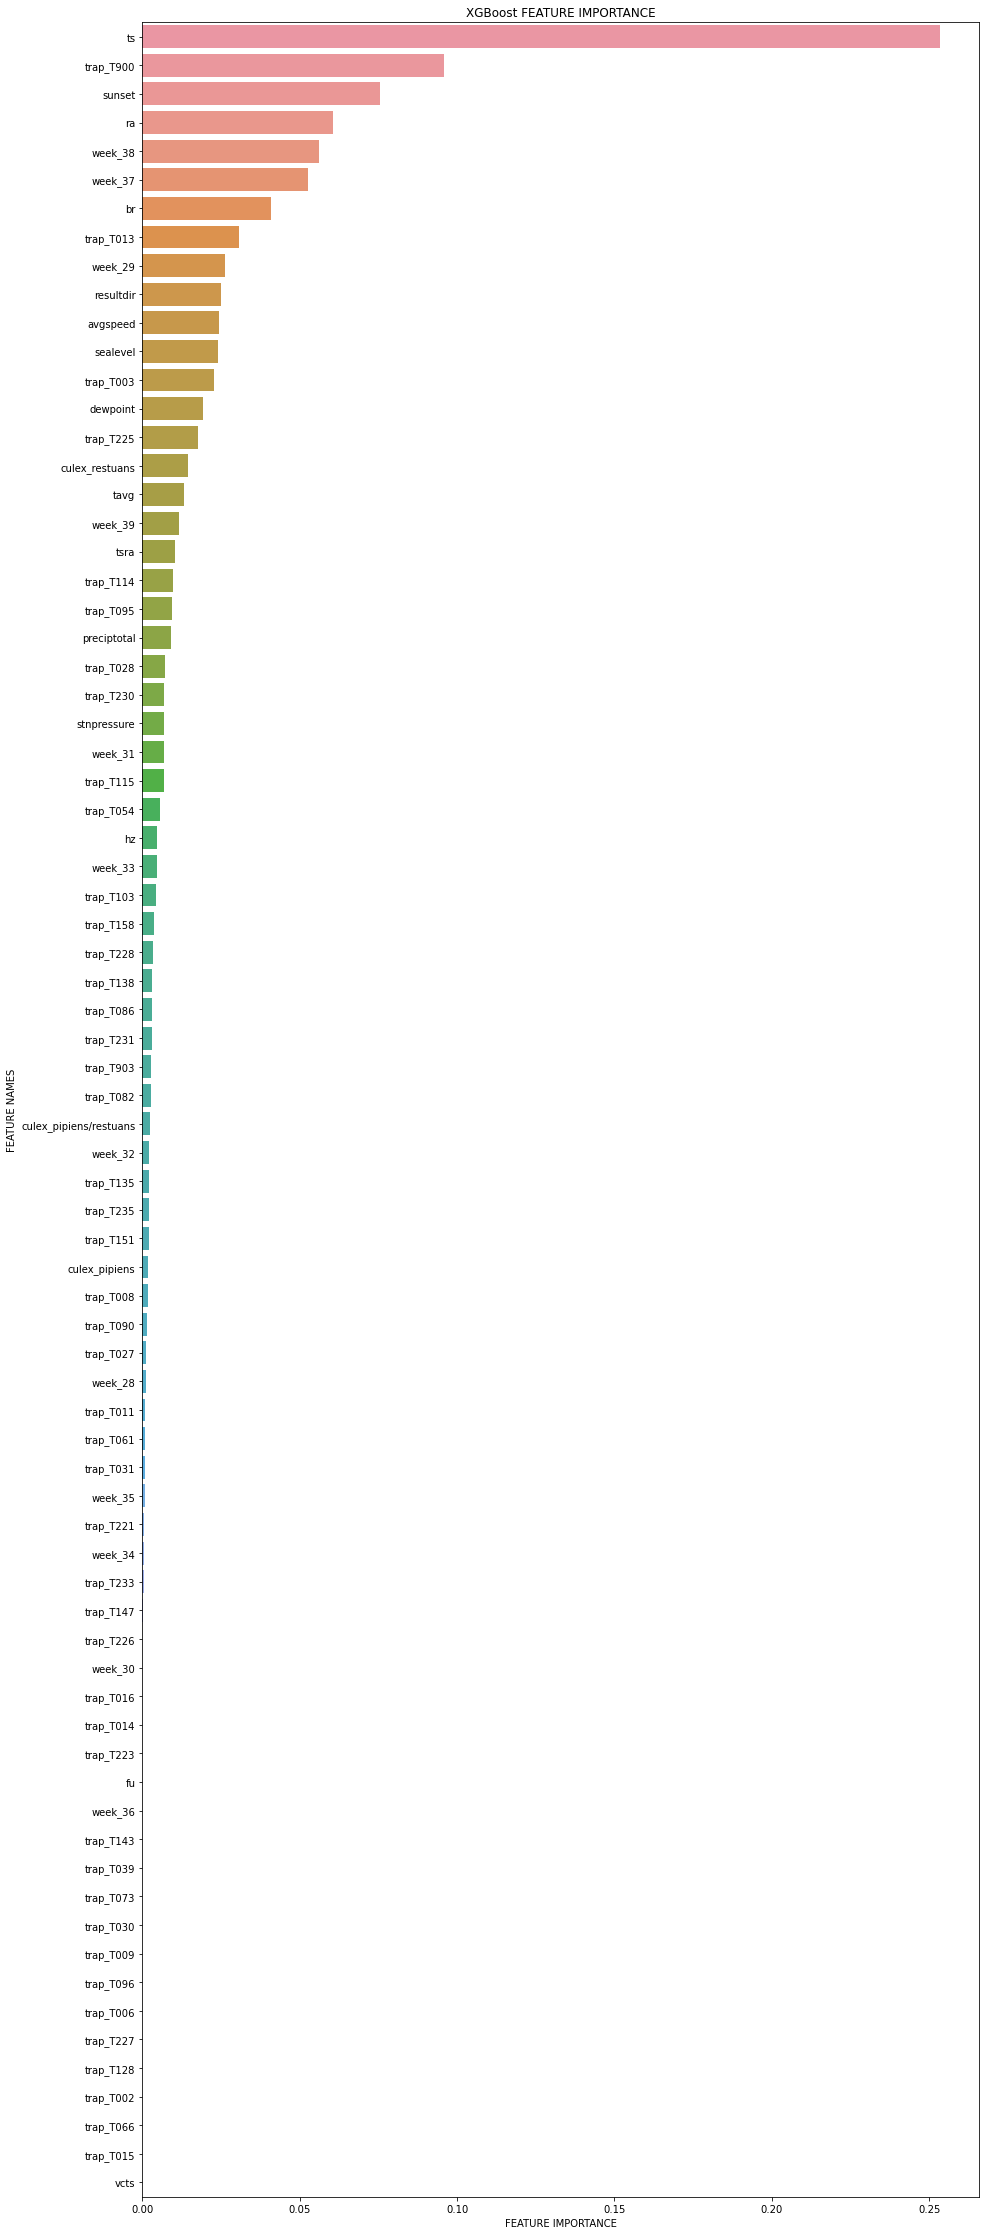

In [ ]:
plot_feature_importance(xbg_model.feature_importances_,X.columns,'XGBoost')

The default feature importance from XGBoost calculates the 'gain', which is the average gain of split which uses the particular feature. We can see that the `ts` - ***Thunderstorm*** appears to be the most important, that could indicate that after a thunderstorm, after 7 days, like there will be more wnv present around the area possibly due to accumulation of stagnant puddles and optimal weather conditions for breeding.  The high importance coming from `ra` - ***Rain*** suggests similar behaviour as well. 


`Week 38 and 37` seems to be highlights as top few features that gives significant gain of split, indicative that these two weeks might be active seasons where wnv may develop. This may serve as a potential indicator that we can focus on spraying methods on these two days specifically for better efficiency. 


# ROC Curve

C:\Users\User\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


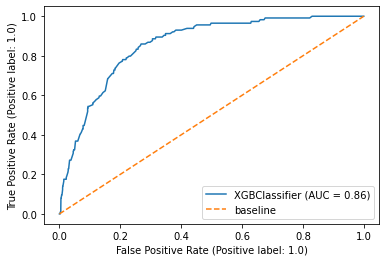

In [ ]:
plot_roc_curve(gs_logreg, X_test_sc, y_test)
plot_roc_curve(rfc_smote_pipe, X_test_sc, y_test)
plot_roc_curve(rfs_hyperparam_bal, X_test_sc, y_test)
plot_roc_curve(svc, X_test_sc, y_test)
plot_roc_curve(xbg_model, X_test_sc, y_test)

plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

The above plot shows the ROC curve for our models, with the best score coming from XGBoost with AUC value of 0.83. Since it is closer to 1, it shows how the model is able to separate both classes quite well.  

# Cost Benefit Analysis